In [3]:
import requests
import pandas as pd
import geopandas as gpd

import sys

sys.path.append("../")

# from helper_functions import *
# from loading_data import *
from Code.helper_functions import initial_loading
from Code.algorithms import random_start_hillclimber

POSTGRES password?WelkomCorne!


### Locations per cluster
The first step is to slightly modify the loading of the clusters

In [ ]:
def load_api_data(prnt=False):
    """
    This function loads in information on the current composition of container
    clusters in Amsterdam. It uses the API from data.amsterdam.nl (available at
    'https://api.data.amsterdam.nl/vsd/afvalclusters'). It returns the coordinates,
    amount and volume of different fractions and the address of the clusters. As
    a check, it is determined whether or not the cluster is currently active.
    Returns:
    - df containing coordinates, dict-like amount and volume per fraction and
    address.
    """
    x_coordinates = []
    y_coordinates = []
    aantal = []
    volumes = []
    adresses = []
    buurt = []

    link = 'https://api.data.amsterdam.nl/vsd/afvalclusters'

    while link != None: #This is the case on the last page of the API
        if prnt: # Can be used for some kind of monitoring of progres
            print(link)
        response = requests.get(link)
        output = response.json()
        for result in output['results']:
            if result['cluster_datum_einde_cluster'] == None: #Als het cluster nog actief is
                x_coordinates.append(str(result['cluster_geometrie']['coordinates'][0]))
                y_coordinates.append(str(result['cluster_geometrie']['coordinates'][1]))
                aantal.append(result['cluster_fractie_aantal'])
                volumes.append(result['cluster_fractie_volume'])
                adresses.append(result['bag_adres_openbare_ruimte_naam'])
                buurt.append(result['gbd_buurt_code'])
        try:
            link = output['_links']['next']['href'] #Retrieve link for next page
        except:
            link = None #True for last page of API

    df_clusters = pd.DataFrame([x_coordinates, y_coordinates, aantal, volumes, adresses, buurt]).T
    df_clusters = df_clusters.rename(columns={0: 'cluster_x', 1:'cluster_y', 2:'aantal_per_fractie', 3:'volume_per_fractie', 4: 'street_name', 5:'buurt'})
    # Transform coordinates of clusters to ints, as this helps easing join
    df_clusters['cluster_x'] = df_clusters['cluster_x'].astype('float').round(0).astype('int')
    df_clusters['cluster_y'] = df_clusters['cluster_y'].astype('float').round(0).astype('int')
    df_clusters['wijk'] = df_clusters['buurt'].str[:3]
    df_clusters['stadsdeel'] = df_clusters['buurt'].str[0]
    return df_clusters

In [ ]:
def load_geodata_containers(subsectie=None):
    """
    This function loads in all polygons representing areas in the city of Amsterdam
    where general waste needs to be brought to a container. This is different
    from the alternative where general waste is collected from the sidewalk. This
    is needed to filter the address POI's to relevant POI's for optimization.
    Subsectie is optional parameter to filter on specific stadsdelen. This can be used
    for partial optimization.

    Returns:
    - List of polygons making up the area of centralized garbage collection
    """

    source = gpd.read_file('../data/Inzameling_huisvuil_100220.shp')
    source = source[source['aanbiedwij'] == 'Breng uw restafval  naar een container voor restafval.']
    if subsectie:
        source = source[source['sdcode'] == subsectie]
    return list(source.geometry)

In [ ]:
def get_db_afvalcluster_info():
    """
    Function that modifies loads in data on the garbage clusters from the Postgres
    database and modifies the resulting dataframe in a way that makes it usable
    for future analysis
    Returns:
    - pandas DataFrame containing all information from the database and also the
    added coordinates for the clusters and the type of POI
    """
    polygon_list = load_geodata_containers()
    db_df = get_dataframe("""SELECT *
                             FROM proj_afval_netwerk.afv_rel_nodes_poi
                             """)
    db_df['woning'] = db_df['bk_afv_rel_nodes_poi'].str.split('~')
    db_df['cluster_x'] = db_df['woning'].apply(lambda x: x[0]).astype('float').round(0).astype('int')
    db_df['cluster_y'] = db_df['woning'].apply(lambda x: x[1]).astype('float').round(0).astype('int')
    db_df['type'] = db_df['woning'].apply(lambda x: x[2])
    db_df['bag'] = db_df['woning'].apply(lambda x: x[3])
    print('a')
#     db_df['uses_container'] = db_df.apply(lambda row: address_in_service_area(row['cluster_x'], row['cluster_y'], polygon_list = polygon_list), axis=1)
    db_df = db_df.drop('woning', axis=1)
    return db_df

In [ ]:
def create_all_households(rel_poi_df, subsectie=None):
    """
    Function that creates a dataframe containing all households as rows
    """
    polygon_list = load_geodata_containers(subsectie = subsectie)
    all_households = rel_poi_df[rel_poi_df['type']!='afval_cluster']
    all_households = all_households[['s1_afv_nodes', 'cluster_x', 'cluster_y']]
    print('b')
    all_households['uses_container'] = all_households.apply(lambda row: address_in_service_area(row['cluster_x'], row['cluster_y'], polygon_list=polygon_list), axis=1)
    return all_households

In [ ]:
df_clusters = load_api_data_neigborhood()

In [ ]:
df_clusters['stadsdeel'].value_counts()
# Stadsdeel Zuid-Oost (T) has 423 clusters. This is to be optimized

In [ ]:
rel_poi_df = get_db_afvalcluster_info()

In [ ]:
all_households = create_all_households(rel_poi_df, subsectie='T')

In [ ]:
joined = join_api_db(rel_poi_df, df_clusters)

In [ ]:
joined['rest'], joined['plastic'], joined['papier'], joined['glas'], joined['textiel'], joined['totaal'] = zip(*joined['aantal_per_fractie'].apply(lambda x: containers_per_cluster(x)))

In [ ]:
df_afstandn2 = distance_matrix_with_counts()

In [ ]:
for i in ['T', 'M', 'N', 'A', 'K', 'E', 'F', 'B']:
    print(i)
    all_households, rel_poi_df, joined, df_afstandn2 = initial_loading(use_count=True, subsectie=i)
    joined_cluster_distance, good_result_rich, aansluitingen, avg_distance, penalties = \
    analyze_candidate_solution(joined, all_households, rel_poi_df, df_afstandn2, clean=True, use_count=True)

Do you want to use addresses instead of clusters?True
What stadsdeel do you want to make as a subsection?T
API data loaded
DB relation POIs loaded
Table all households created
API and DB joined
containers per cluster determined


..\Code\loading_data.py:239: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  verblijfsobjecten['bag'] = verblijfsobjecten['split'].apply(lambda x: x[3]).astype('int64')


distance matrix loaded
How many random iterations?10
How many iterations hillclimber?20
Do you want the results saved(True/False)?True
Do you want to only use a subset of data?Ture
Do you want to use addresses instead of clusters?True
What parameter to optimize on (score/penalties)?penalties
Average distance is : 249.6004611676881
Penalties are: 308.1859662117452
Average distance is : 254.02442956940632
Penalties are: 319.9085892115329
Average distance is : 251.95626616743436
Penalties are: 320.9413878810317
Average distance is : 254.4581740794967
Penalties are: 335.33427856672427
Average distance is : 258.37575446499943
Penalties are: 325.6733294122486
Average distance is : 257.2809305525734
Penalties are: 340.44575707527764
Average distance is : 256.8267005819576
Penalties are: 334.76564096816645
Average distance is : 263.8342913062763
Penalties are: 336.82620506334325
Average distance is : 260.2847936184146
Penalties are: 324.4653209068839
Average distance is : 250.34930114917154
Pe

..\Code\algorithms.py:123: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  today = str(pd.datetime.now().date()) + '-' + str(pd.datetime.now().hour)


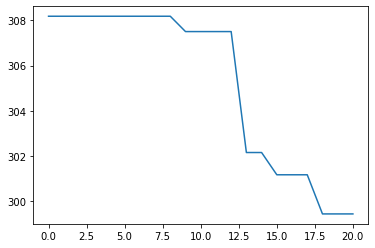

In [4]:
all_households, rel_poi_df, joined, df_afstandn2 = initial_loading()
hill_df, best_solution = random_start_hillclimber(joined, all_households, rel_poi_df, df_afstandn2)

In [ ]:
hill_df, best_solution = random_start_hillclimber(joined, all_households, rel_poi_df, df_afstandn2)

How many random iterations?50
How many iterations hillclimber?1000
Do you want the results saved(True/False)?True
Do you want to only use a subset of data?True
Do you want to use addresses instead of clusters?True
What parameter to optimize on (score/penalties)?penalties
Average distance is : 249.6004611676881
Penalties are: 308.1859662117452
Average distance is : 256.8501165254244
Penalties are: 318.06544566692725
Average distance is : 257.65663841909384
Penalties are: 329.18789652972174
Average distance is : 264.42263133898905
Penalties are: 317.1555951048951
Average distance is : 264.0940907175675
Penalties are: 326.34529333251066
Average distance is : 256.91636230475126
Penalties are: 326.9116761959607
Average distance is : 268.52097579063326
Penalties are: 323.672936915984
Average distance is : 263.75628282235
Penalties are: 323.1913549865229
Average distance is : 267.1983497018804
Penalties are: 335.19606141505557
Average distance is : 256.12829477431114
Penalties are: 323.280846

Average distance is : 248.63553488963862
Penalties are: 292.8425774744738
292.8425774744738 292.0013859554074
Average distance is : 248.9748410755179
Penalties are: 293.66762521344384
293.66762521344384 292.0013859554074
Average distance is : 249.54374512978066
Penalties are: 293.42342471348195
293.42342471348195 292.0013859554074
Average distance is : 251.60572102673183
Penalties are: 301.66948209969155
301.66948209969155 292.0013859554074
Average distance is : 248.8175632619261
Penalties are: 290.9900570952281
290.9900570952281 292.0013859554074
Average distance is : 249.07060029157446
Penalties are: 295.62232320706755
295.62232320706755 290.9900570952281
Average distance is : 249.65514292138704
Penalties are: 296.4055692644301
296.4055692644301 290.9900570952281
Average distance is : 248.74502556089467
Penalties are: 291.5336877266096
291.5336877266096 290.9900570952281
Average distance is : 248.87034959159058
Penalties are: 289.4803264221713
289.4803264221713 290.9900570952281
Aver

Average distance is : 254.30885327007775
Penalties are: 290.5229784982082
290.5229784982082 283.1988482998583
Average distance is : 251.99246028050277
Penalties are: 282.211874843737
282.211874843737 283.1988482998583
Average distance is : 252.69785990720897
Penalties are: 281.5510479186633
281.5510479186633 282.211874843737
Average distance is : 252.22129016810777
Penalties are: 282.0171881745072
282.0171881745072 281.5510479186633
Average distance is : 253.57930129177527
Penalties are: 288.4951756739864
288.4951756739864 281.5510479186633
Average distance is : 253.2652672606855
Penalties are: 282.66680340847535
282.66680340847535 281.5510479186633
Average distance is : 252.70409995783803
Penalties are: 282.6106479228301
282.6106479228301 281.5510479186633
Average distance is : 259.74446928766884
Penalties are: 286.514014375599
286.514014375599 281.5510479186633
Average distance is : 253.59503712565515
Penalties are: 284.77274667694485
284.77274667694485 281.5510479186633
Average dist

Average distance is : 258.7716556664568
Penalties are: 277.2789302054252
277.2789302054252 276.3031237968248
Average distance is : 257.69290907463625
Penalties are: 276.90227201133376
276.90227201133376 276.3031237968248
Average distance is : 258.15149283245137
Penalties are: 280.7640168965374
280.7640168965374 276.3031237968248
Average distance is : 257.96004606591424
Penalties are: 278.70298772865533
278.70298772865533 276.3031237968248
Average distance is : 257.38182887331214
Penalties are: 278.3368280345014
278.3368280345014 276.3031237968248
Average distance is : 258.13887458616443
Penalties are: 279.84310910871284
279.84310910871284 276.3031237968248
Average distance is : 258.0337266821095
Penalties are: 279.5377505729405
279.5377505729405 276.3031237968248
Average distance is : 257.6532174099788
Penalties are: 281.4806045876911
281.4806045876911 276.3031237968248
Average distance is : 258.0591381263002
Penalties are: 277.9647732250677
277.9647732250677 276.3031237968248
Average 

Average distance is : 258.7494024399201
Penalties are: 276.2522355
276.2522355 274.1501347916667
Average distance is : 258.62711333541273
Penalties are: 273.68314085416665
273.68314085416665 274.1501347916667
Average distance is : 259.41071975188476
Penalties are: 275.6660572916666
275.6660572916666 273.68314085416665
Average distance is : 256.9074269803306
Penalties are: 273.27148218749994
273.27148218749994 273.68314085416665
Average distance is : 256.4569720096419
Penalties are: 280.78423116666664
280.78423116666664 273.27148218749994
Average distance is : 258.2471336053052
Penalties are: 275.3552250625
275.3552250625 273.27148218749994
Average distance is : 257.8520222955205
Penalties are: 277.59360920833336
277.59360920833336 273.27148218749994
Average distance is : 257.7205176590025
Penalties are: 273.29456216666665
273.29456216666665 273.27148218749994
Average distance is : 257.6344136046333
Penalties are: 274.2899302083333
274.2899302083333 273.27148218749994
Average distance i